<a href="https://colab.research.google.com/github/ajaynain-eng/Mask-RCNN/blob/main/mrcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall keras -y
!pip uninstall keras-nightly -y
!pip uninstall keras-Preprocessing -y
!pip uninstall keras-vis -y
!pip uninstall tensorflow -y
!pip uninstall h5py -y
!pip uninstall scikit-image

In [ ]:
!pip install tensorflow-gpu==1.13.1
!pip install keras==2.0.8
!pip install h5py==2.10.0
!pip install scikit-image==0.16.2

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'
ROOT_DIR = "/content/sample_data/Mask_RCNN"

In [5]:
# import shutil
# shutil.rmtree("/content/sample_data/Mask_RCNN")

In [7]:
cd "/content/sample_data"

/content/sample_data


In [8]:
try:
    os.mkdir("/content/sample_data/Mask_RCNN")
except:
    pass

In [9]:
cd "/content/sample_data/Mask_RCNN"

/content/sample_data/Mask_RCNN


In [10]:
!kaggle competitions download -c uw-madison-gi-tract-image-segmentation

 99% 2.28G/2.30G [01:02<00:00, 23.9MB/s]
100% 2.30G/2.30G [01:02<00:00, 39.2MB/s]


In [ ]:
!unzip \*.zip && rm *.zip 

In [12]:
try:
    os.mkdir("mrcnn")
except:
    pass

In [13]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 15.69 MiB/s, done.
Resolving deltas: 100% (565/565), done.


In [14]:
# import shutil
# import os
# subfolders = os.listdir("/content/sample_data/Mask_RCNN/logs")
# for subfolder in subfolders:
#     try:
#         os.mkdir("/content/drive/MyDrive/Kaggle/Mask RCNN/logs/" + subfolder)
#     except:
#         pass
#     files = os.listdir("/content/sample_data/Mask_RCNN/logs/" + subfolder)
#     print(files)
#     for file in files:
#         shutil.copy2("/content/sample_data/Mask_RCNN/logs/"+subfolder+"/"+file, "/content/drive/MyDrive/Kaggle/Mask RCNN/logs/"+subfolder+"/"+file)

In [15]:
import shutil
files = os.listdir("/content/sample_data/Mask_RCNN/Mask_RCNN/mrcnn")
# files = os.listdir("/content/drive/MyDrive/Kaggle/Mask RCNN/mrcnn")
for file in files:
    shutil.copy2("/content/sample_data/Mask_RCNN/Mask_RCNN/mrcnn/"+ file , ROOT_DIR+"/mrcnn/" + file)
shutil.rmtree("/content/sample_data/Mask_RCNN/Mask_RCNN/")

In [16]:
# ROOT_DIR = "/content/drive/MyDrive/Kaggle/Mask RCNN"
coco_url = "https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5"
import requests
response = requests.get(coco_url)
with open(ROOT_DIR + "/mask_rcnn_coco.h5", "wb") as file:
    file.write((response.content))

In [17]:
os.getcwd()

'/content/sample_data/Mask_RCNN'

In [18]:
# os.rename("/content/sample_data/Mask_RCNN/mrcnn/model.py", "/content/sample_data/Mask_RCNN/mrcnn/model_temp.py")
# temp_file = open("/content/sample_data/Mask_RCNN/mrcnn/model.py", "w")
# i = 0
# with open("/content/sample_data/Mask_RCNN/mrcnn/model_temp.py", "r") as file:
#     f = file.readlines()
#     for i, line in enumerate(f):
#         if i == 22:
#             temp_file.write("import keras.engine.base_layer as KE\n")
#         else:
#             temp_file.write(line)
# temp_file.close()

In [ ]:
import pandas as pd
import numpy as np
import cv2
from cv2 import resize
import sys
import json
import datetime
import skimage.draw
import cv2
from glob import glob
import tensorflow as tf
from tensorflow import keras
from mrcnn import visualize
from mrcnn.visualize import display_instances
import matplotlib.pyplot as plt

import skimage
from skimage import io, img_as_float, img_as_ubyte
from skimage.measure import label, regionprops, find_contours

# Root directory of the project
# ROOT_DIR = "D:\MaskRCNN"
# ROOT_DIR = "/content/drive/MyDrive/Kaggle/Mask RCNN"

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library  
from mrcnn.config import Config
from mrcnn import model as modellib, utils

In [20]:
print("tensorflow: ",tf.__version__)
print("keras: ", keras.__version__)

tensorflow:  1.13.1
keras:  2.2.4-tf


In [21]:
df = pd.read_csv("/content/sample_data/Mask_RCNN/train.csv")
sub_df = df.drop(columns=['class','segmentation']).drop_duplicates()
df.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [22]:
df['label'] = df["class"].map({"large_bowel":1, "small_bowel":2, "stomach":3})

In [23]:
df.head()

,id,class,segmentation,label
0,case123_day20_slice_0001,large_bowel,NaN,1
1,case123_day20_slice_0001,small_bowel,NaN,2
2,case123_day20_slice_0001,stomach,NaN,3
3,case123_day20_slice_0002,large_bowel,NaN,1
4,case123_day20_slice_0002,small_bowel,NaN,2


In [24]:
print("df shape: ", df.shape)
print("sub_df shape: ", sub_df.shape)
print("unique ids: ", df.shape[0]//3)

df shape:  (115488, 4)
sub_df shape:  (38496, 1)
unique ids:  38496


In [25]:
paths = glob(f"/content/sample_data/Mask_RCNN/train/**/*png", recursive = True)
# paths = glob(f'/kaggle/input/uw-madison-gi-tract-image-segmentation/train/**/*/png',recursive=True)

dct = {}
paths.sort()
for path in paths:
    case, day = path.split("/")[6].split("_")
    slice = path.split("/")[8].split("_")[1]
    key = case + "_" + day + "_slice_" + slice
    dct[key] = path

In [26]:
df["image_path"] = df["id"].map(dct)

In [27]:
df.head()

,id,class,segmentation,label,image_path
0,case123_day20_slice_0001,large_bowel,NaN,1,/content/sample_data/Mask_RCNN/train/case123/c...
1,case123_day20_slice_0001,small_bowel,NaN,2,/content/sample_data/Mask_RCNN/train/case123/c...
2,case123_day20_slice_0001,stomach,NaN,3,/content/sample_data/Mask_RCNN/train/case123/c...
3,case123_day20_slice_0002,large_bowel,NaN,1,/content/sample_data/Mask_RCNN/train/case123/c...
4,case123_day20_slice_0002,small_bowel,NaN,2,/content/sample_data/Mask_RCNN/train/case123/c...


In [28]:
def get_metadata(row):
    data = row['id'].split('_')
    case = int(data[0].replace('case',''))
    day = int(data[1].replace('day',''))
    slice_ = int(data[-1])
    row['case'] = case
    row['day'] = day
    row['slice'] = slice_
    return row

def path2info(row):
    path = row['image_path']
    data = path.split('/')
    slice_ = int(data[-1].split('_')[1])
    case = int(data[-3].split('_')[0].replace('case',''))
    day = int(data[-3].split('_')[1].replace('day',''))
    width = int(data[-1].split('_')[2])
    height = int(data[-1].split('_')[3])
    row['height'] = height
    row['width'] = width
    row['case'] = case
    row['day'] = day
    row['slice'] = slice_
    return row

In [29]:
# df = df.apply(lambda x: path2info(x),axis=1)
# print("path_df: ", df.shape)
# df.head()

In [30]:
# new_df = sub_df.merge(path_df, on=['case','day','slice'], how='left')
df["case_id_str"] = df["id"].apply(lambda x: x.split("_", 2)[0])
df["day_num_str"] = df["id"].apply(lambda x: x.split("_", 2)[1])
df["slice_id"] = df["id"].apply(lambda x: x.split("_", 2)[2])
print("new_df shape: ", df.shape)
df.head()

new_df shape:  (115488, 8)


,id,class,segmentation,label,image_path,case_id_str,day_num_str,slice_id
0,case123_day20_slice_0001,large_bowel,NaN,1,/content/sample_data/Mask_RCNN/train/case123/c...,case123,day20,slice_0001
1,case123_day20_slice_0001,small_bowel,NaN,2,/content/sample_data/Mask_RCNN/train/case123/c...,case123,day20,slice_0001
2,case123_day20_slice_0001,stomach,NaN,3,/content/sample_data/Mask_RCNN/train/case123/c...,case123,day20,slice_0001
3,case123_day20_slice_0002,large_bowel,NaN,1,/content/sample_data/Mask_RCNN/train/case123/c...,case123,day20,slice_0002
4,case123_day20_slice_0002,small_bowel,NaN,2,/content/sample_data/Mask_RCNN/train/case123/c...,case123,day20,slice_0002


In [31]:
# test_data = []

# for group in test_df.groupby(["case_id_str", "day_num_str"]):

#     case_id_str, day_num_str = group[0]
#     group_id = case_id_str + "_" + day_num_str
#     group_df = group[1].sort_values("slice_id", ascending=True)
#     n_slices = group_df.shape[0]
#     group_slices, group_ids = [], []
#     for idx in range(n_slices):
#         slc = group_df.iloc[idx]
#         group_slices.append(slc.image_path)
#         group_ids.append(slc.id)
#     test_data.append({"image": group_slices, "id": group_ids})

In [32]:
temp = df["segmentation"].isna()
train_df = df[[not tmp for tmp in temp]]
test_df = df[temp]
val_df = train_df[30000:]
train_df = train_df[:30000]
print("train_df shape: ", train_df.shape)
print("val_df shape: ", val_df.shape)
print("test_df shape: ", test_df.shape)

train_df shape:  (30000, 8)
val_df shape:  (3913, 8)
test_df shape:  (81575, 8)


In [33]:
train_df = train_df.reset_index(drop = True)
val_df = val_df.reset_index(drop = True)
test_df = test_df.reset_index(drop = True)

In [34]:
# temp = []
# for id, sub_group in df.groupby("id"):
#     if sub_group["segmentation"].isna().sum()>0:
#         temp+=[True, True, True]
#     else:
#         temp+=[False, False, False]

In [35]:
train_df.isna().sum()

id              0
class           0
segmentation    0
label           0
image_path      0
case_id_str     0
day_num_str     0
slice_id        0
dtype: int64

In [36]:
def mask_to_border(mask):
    h, w = mask.shape
    border = np.zeros((h,w))
    contours = find_contours(mask, 0.5)
    for contour in contours:
        for c in contour:
            x = int(c[0])
            y = int(c[1])
            border[x][y] = 1
    return border

def mask_to_bbox(mask):
    bboxes = []
    border = mask_to_border(mask)
    lbl = label(border)
    props = regionprops(lbl)
    for prop in props:
        x1 = prop.bbox[0]
        y1 = prop.bbox[1]
        x2 = prop.bbox[2]
        y2 = prop.bbox[3]
        bboxes.append([x1,y1, x2, y2])
    return bboxes

In [37]:
def image_to_mask(shape, seg):
    mask = np.zeros(shape)
    temp = seg.split(" ")

    all_loc = []
    b_boxes = []
    for i in range(len(temp)//2):
        loc = int(temp[i*2])
        rng = int(temp[i*2+1])
        all_loc += [loc+a for a in range(rng)]
    all_loc.sort()
    
    temp_row = []
    temp_col = []
    for j,i in enumerate(all_loc):
        row = i//shape[1]
        col = i - row*shape[1]
        mask[row, col] = 1
    return mask

In [38]:
train_df['image_path'].iloc[5].split("/")[-1]

'slice_0070_266_266_1.50_1.50.png'

In [39]:
os.mkdir("dataset")
os.mkdir("dataset/train")
os.mkdir("dataset/val")
os.mkdir("dataset/test")

In [40]:
def Annot(preprocess_path, df, train_or_val, res=0.6, surf=100, eps=0.01):
    if train_or_val == "train":
        base_dir = "/content/sample_data/Mask_RCNN/dataset/train/"
    else:
        base_dir = "/content/sample_data/Mask_RCNN/dataset/val/"
    jsonf = {} # only one big annotation file
    with open(os.path.join(base_dir, "via_project.json"), 'w') as js_file:
        gt_path = os.path.join(preprocess_path, 'gt')
        # images_path = os.path.join(preprocess_path, 'images')
        images_path = df["image_path"].values.tolist()
        seg = df["segmentation"].values.tolist()
        labels = df["class"].values.tolist()
        # All the elements in the images folders
        # lst = os.listdir(images_path)
        lst = df["id"].values.tolist()
        # for elt in tqdm(lst, desc='lst'):
        for i, img_path in enumerate(images_path):
            elt = lst[i]
            label = labels[i]
            # Read the binary mask, and find the contours associated
            # gray = cv2.imread(os.path.join(gt_path, elt))
            # img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = plt.imread(img_path)
            save_path = img_path.split("/")[-1]
            if not os.path.exists(base_dir + save_path):
                img_min = img.min()
                img_max = img.max()
                img_range = img_max - img_min
                img = (img-img_min)/img_range
                img = img.astype("float32")
                plt.imsave(base_dir + save_path, img*255)

            shape = img.shape
            gray = image_to_mask(shape, seg[i])
            imgray = gray*255.0
            # print(imgray.shape)
            # imgray = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)

            # _, thresh = cv2.threshold(imgray, 127, 255, 0)
            # contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            # border = mask_to_border(mask)
            # contours = np.where(border == 1.0)

            _, thresh = cv2.threshold(imgray, 127, 255, 0)
            # thresh = thresh//255
            
            thresh = thresh.astype(np.ubyte)
            # print(thresh.shape)
            contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            
            # https://www.pyimagesearch.com/2021/10/06/opencv-contour-approximation/
            # Contours approximation based on Ramer–Douglas–Peucker (RDP) algorithm
            areas = [cv2.contourArea(contours[idx])*res*res for idx in range(len(contours))]
            large_contour = []
            for i in range(len(areas)):
                if areas[i]>surf:
                    large_contour.append(contours[i])
            approx_contour = [cv2.approxPolyDP(c, eps * cv2.arcLength(c, True), True) for c in large_contour]
            
            # -------------------------------------------------------------------------------
            # BUILDING VGG ANNTOTATION TOOL ANNOTATIONS LIKE 
            if len(approx_contour) > 0:
                regions = [0 for i in range(len(approx_contour))]
                for i in range(len(approx_contour)):
                    shape_attributes = {}
                    region_attributes = {}
                    region_attributes['name'] = label
                    regionsi = {}
                    shape_attributes['name'] = 'polygon'
                    shape_attributes['all_points_x'] = approx_contour[i][:, 0][:, 0].tolist()
                    # https://stackoverflow.com/questions/26646362/numpy-array-is-not-json-serializable
                    shape_attributes['all_points_y'] = approx_contour[i][:, 0][:, 1].tolist()
                    regionsi['shape_attributes'] = shape_attributes
                    regionsi['region_attributes'] = region_attributes
                    regions[i] = regionsi

                size = os.path.getsize(img_path)
                name = elt + str(size)
                json_elt = {}
                json_elt['filename'] = save_path 
                json_elt['size'] = str(size)
                json_elt['regions'] = regions
                json_elt['file_attributes'] = {}
                jsonf[name] = json_elt
                
        json.dump(jsonf, js_file) 

In [41]:
preprocess_path = "/content/sample_data/Mask_RCNN/train"
Annot(preprocess_path, train_df, "train", res=0.6, surf=100, eps=0.01)
Annot(preprocess_path, val_df, "val", res=0.6, surf=100, eps=0.01)

In [42]:
# preprocess_path = "/content/sample_data/Mask_RCNN/train"
# Annot(preprocess_path, val_df, "val", res=0.6, surf=100, eps=0.01)

In [43]:
with open("/content/sample_data/Mask_RCNN/dataset/train/via_project.json") as file:
    data = json.load(file)

(276, 276, 4)


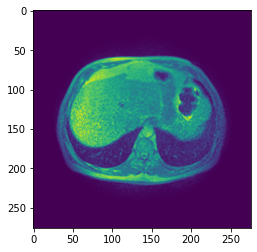

In [44]:
print(plt.imread("/content/sample_data/Mask_RCNN/dataset/train/slice_0002_276_276_1.63_1.63.png").shape)
plt.imshow(plt.imread("/content/sample_data/Mask_RCNN/dataset/train/slice_0002_276_276_1.63_1.63.png"))
plt.show()

(310, 360)


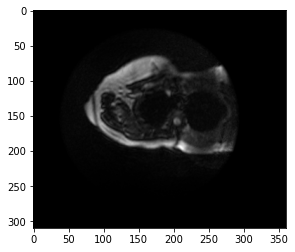

In [45]:
print(plt.imread("/content/sample_data/Mask_RCNN/train/case102/case102_day0/scans/slice_0005_360_310_1.50_1.50.png").shape)
plt.imshow(plt.imread("/content/sample_data/Mask_RCNN/train/case102/case102_day0/scans/slice_0005_360_310_1.50_1.50.png"), cmap = "gray")
plt.show()

In [46]:
test_imgs_path = test_df["image_path"].values.tolist()
for img_path in test_imgs_path:
    save_path = img_path.split("/")[-1]
    if not os.path.exists("/content/sample_data/Mask_RCNN/dataset/test/" + save_path):
        img = plt.imread(img_path)
        # img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_min = img.min()
        img_max = img.max()
        img_range = img_max - img_min
        img = (img-img_min)/img_range
        img = img.astype("float32")
        plt.imsave("/content/sample_data/Mask_RCNN/dataset/test/" + save_path, img*255)
        # cv2.imwrite("/content/sample_data/Mask_RCNN/dataset/val/" + save_path, img)

In [ ]:
ROOT_DIR

In [ ]:
plt.imread("/content/sample_data/Mask_RCNN/dataset/train/slice_0002_276_276_1.63_1.63.png").shape

In [ ]:
plt.imshow(plt.imread("/content/sample_data/Mask_RCNN/dataset/train/slice_0003_276_276_1.63_1.63.png")[:,:,1])

In [ ]:
# train_imgs = os.listdir("/content/sample_data/Mask_RCNN/dataset/train")
# for img in train_imgs:
#     if (img == "via_project.json") or (img == "mask_rcnn_coco.h5"):
#         pass
#     else:
#         path = os.path.join("/content/sample_data/Mask_RCNN/dataset/train", img)
#         plt.imsave(path, plt.imread(path).astype("float32"))

In [51]:
# val_imgs = os.listdir("/content/sample_data/Mask_RCNN/dataset/val")
# for img in val_imgs:
#     if (img == "via_project.json") or (img == "mask_rcnn_coco.h5"):
#         pass
#     else:
#         path = os.path.join("/content/sample_data/Mask_RCNN/dataset/val", img)
#         plt.imsave(path, plt.imread(path).astype("float32"))

In [ ]:
import gc
for i in range(10):
    gc.collect()

In [53]:
class CustomConfig(Config):
    NAME = "object"
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3 

    STEPS_PER_EPOCH = 10

    # freeze_blocks: "[0,1]"

    DETECTION_MIN_CONFIDENCE = 0.9

############################################################
#  Dataset
############################################################
dataset_dir = "/content/sample_data/Mask_RCNN/dataset"
class CustomDataset(utils.Dataset):
    def load_custom(self, dataset_dir, subset):
        # Add classes. We have only one class to add.
        self.add_class("object", 1, "large_bowel")
        self.add_class("object", 2, "small_bowel")
        self.add_class("object", 3, "stomach")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        annotations1 = json.load(open("/content/sample_data/Mask_RCNN/dataset/" + str(subset) + "/via_project.json")) 
        # print(annotations1)
        annotations = list(annotations1.values())

        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
            # print(a)
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['name'] for s in a['regions']]
            print("objects:",objects)

            name_dict = {"large_bowel": 1,"small_bowel": 2, "stomach": 3} #,"xyz": 3}
            num_ids = [name_dict[a] for a in objects]
     
            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path).astype("float32")
            height, width = image.shape[:2]

            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids 

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [54]:
# class MyCallback(tf.keras.callbacks.Callback):
#     def __init__(self)

In [62]:
config = CustomConfig()
config.BACKBONE = "resnet50"

In [63]:
config.WEIGHT_DECAY = 0.00001

In [64]:
def train(model, epochs = 10, lr = 0.001):
    """Train the model."""
    # Training dataset.
    dataset_train = CustomDataset()
    dataset_train.load_custom("/content/sample_data/Mask_RCNN/dataset", "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = CustomDataset()
    dataset_val.load_custom("/content/sample_data/Mask_RCNN/dataset", "val")
    dataset_val.prepare()

    print("Training network heads")

    model.train(dataset_train, dataset_val,
                learning_rate=lr,
                epochs=epochs,
                layers="all",
                )
                # layers=["heads", "all"])

In [ ]:
# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

model = modellib.MaskRCNN(mode="training", config=config, model_dir=DEFAULT_LOGS_DIR)

weights_path = COCO_WEIGHTS_PATH
        # Download weights file
if not os.path.exists(weights_path):
    utils.download_trained_weights(weights_path)


# def state_modifier(state_dict):
#     state_dict.pop("mask.conv5.bias")
#     state_dict.pop("mask.conv5.weight")
#     state_dict.pop("classifier.linear_class.bias")
#     state_dict.pop("classifier.linear_class.weight")
#     state_dict.pop("classifier.linear_bbox.bias")
#     state_dict.pop("classifier.linear_bbox.weight")
#     return state_dict

# model.load_weights(weights_path)

model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

train(model, epochs = 100, lr = 0.0001)

In [ ]:
# Inspect the model in training or inference modes values: 'inference' or 'training'
TEST_MODE = "inference"
ROOT_DIR = "/content/sample_data/Mask_RCNN/dataset"

def get_ax(rows=1, cols=1, size=16):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax



# Load validation dataset
# Must call before using the dataset
CUSTOM_DIR = "/content/sample_data/Mask_RCNN/dataset"
dataset = CustomDataset()
dataset.load_custom(CUSTOM_DIR, "val")
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

In [67]:
new_model = modellib.MaskRCNN(mode="inference", config=config, model_dir=DEFAULT_LOGS_DIR)
# weight_path = glob("/content/sample_data/Mask_RCNN/logs/**/*0099.h5")[0]
weight_path = "/content/sample_data/Mask_RCNN/mask_rcnn_coco.h5"
new_model.load_weights(weight_path, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])
# new_mode =  new_model.load_weights("/content/sample_data/Mask_RCNN/logs/object20220709T0405/mask_rcnn_object_0099.h5")

Instructions for updating:
Use tf.cast instead.


In [ ]:
import matplotlib.image as mpimg
image1 = mpimg.imread("/content/sample_data/Mask_RCNN/dataset/train/slice_0008_276_276_1.63_1.63.png")
plt.imshow(image1)

In [69]:
results1 = new_model.detect([image1[:,:,:3]], verbose=1)

Processing 1 images
image                    shape: (276, 276, 3)         min:    0.00392  max:    0.99216  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max: -103.34314  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


In [70]:
results1[0]

{'class_ids': array([], dtype=int32),
 'masks': array([], shape=(276, 276, 0), dtype=float64),
 'rois': array([], shape=(0, 4), dtype=int32),
 'scores': array([], dtype=float32)}


*** No instances to display *** 



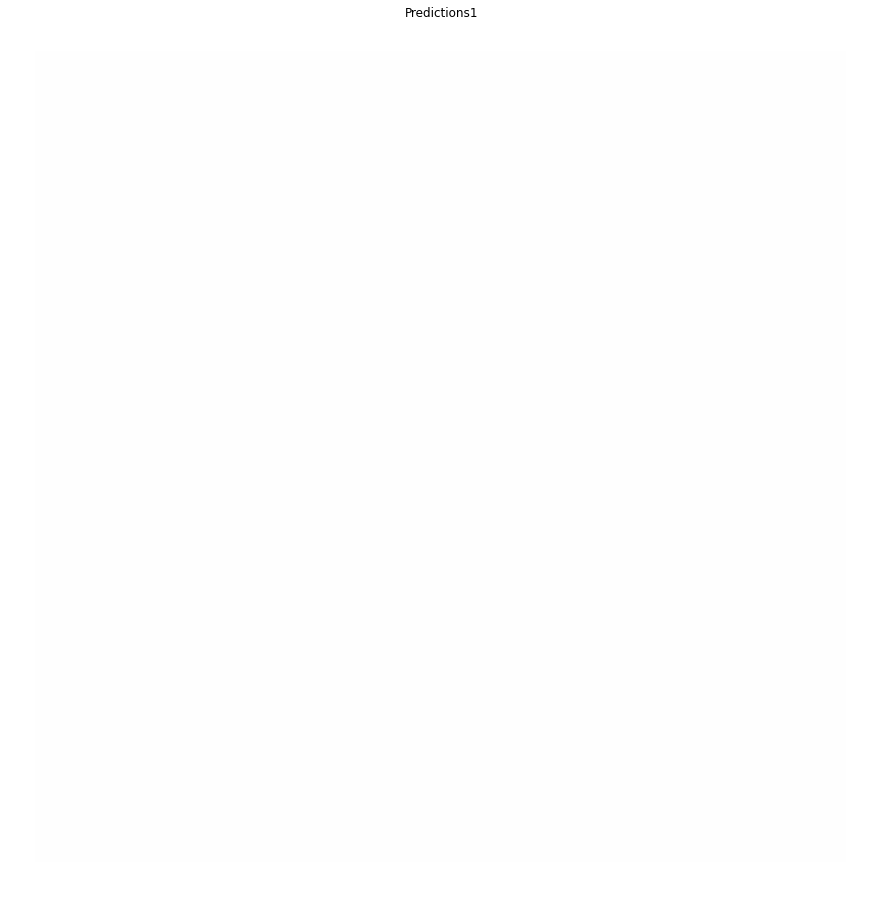


*** No instances to display *** 



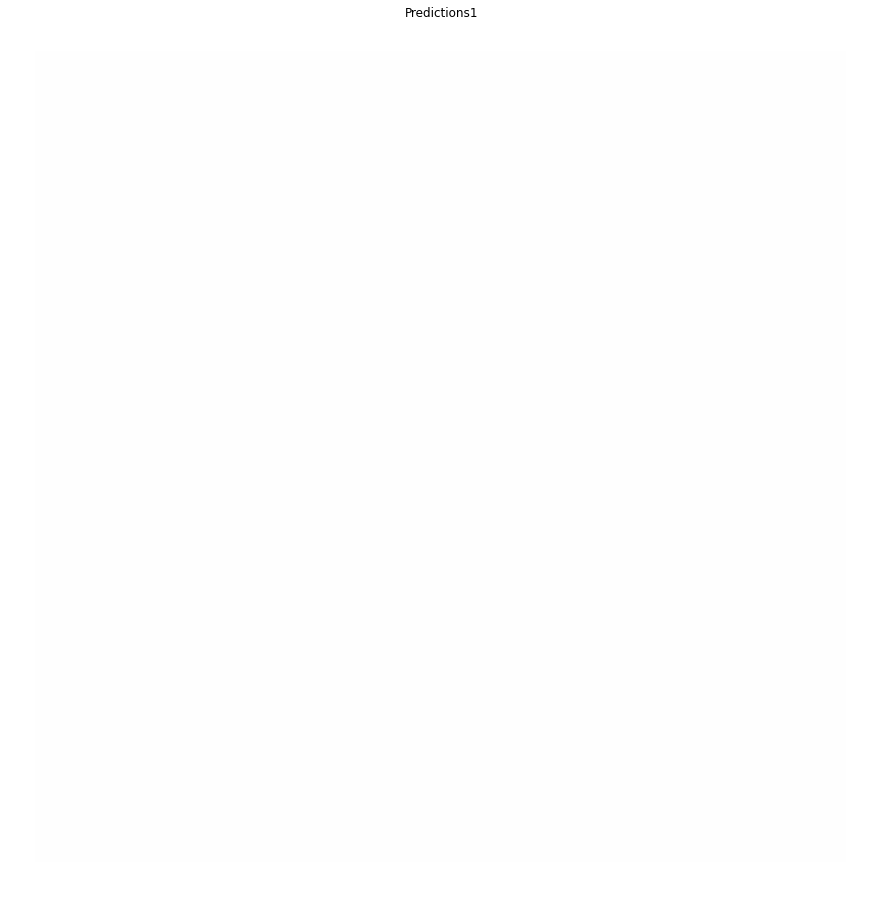

In [71]:
ax = get_ax(1)
r1 = results1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
dataset.class_names, r1['scores'], ax=ax, title="Predictions1")